# Bibliotecas

In [1]:
import spacy 
#Biblioteca de Processamento de Linguagem Natural (NLP) de alto desempenho. 
#Usada para tokenização, lematização, análise sintática, entidades nomeadas, etc.

#import spacy.cli
# Interface de linha de comando do spacy, útil para baixar modelos (spacy.cli.download("en_core_web_sm")).

import numpy as np
#Biblioteca para operações com arrays e álgebra linear. Base para cálculos numér

import pandas as pd
#Manipulação e análise de dados estruturados em DataFrames (tabelas).

import matplotlib.pyplot as plt
#Criação de gráficos básicos (linhas, barras, dispersão, etc.)

import seaborn as sns
#Interface de alto nível para gráficos estatísticos, baseada no matplotlib. Mais bonito e simplificado.

import re
#Expressões regulares para manipulação e limpeza de texto

import joblib
#Salvar/carregar objetos Python (como modelos treinados) em disco de forma eficiente.

from tqdm import tqdm
#Barra de progresso para loops, ótimo para visualizar o andamento de processos demorados.

from sklearn.ensemble import RandomForestClassifier
#Modelo de floresta aleatória (conjunto de árvores de decisão).

from sklearn.neural_network import MLPClassifier
#Multilayer Perceptron (rede neural simples).

from sklearn.linear_model import LogisticRegression
#Regressão logística para classificação binária/multiclasse.

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
#Divide os dados em treino e teste, Busca por melhores hiperparâmetros com validação cruzada, Executa validação cruzada e retorna métricas, Validação cruzada com divisão estratificada (mantém proporção de classes).

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#Gera relatório com precisão, recall, F1 e suporte e Matriz de confusão para avaliar classificadores. 

from sklearn.preprocessing import OrdinalEncoder
#Converte categorias em números inteiros.

from imblearn.over_sampling import RandomOverSampler
#Gera cópias aleatórias de exemplos minoritários (oversampling).

from imblearn.under_sampling import RandomUnderSampler
#Remove exemplos aleatórios da classe majoritária (undersampling)

from scipy.stats import loguniform
#Distribuição log-uniforme usada, por exemplo, na escolha de hiperparâmetros com RandomizedSearchCV.

from xgboost import XGBClassifier
#Modelo de classificação baseado em gradient boosting, muito eficient
#e para tarefas estruturadas/tabulares.

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

import warnings
# Ignora todos os avisos (warnings) durante a execução do código — útil para não poluir os logs.

warnings.filterwarnings('ignore')

# Download SPACY

In [9]:
!python -m spacy download pt_core_news_md

     ---------------------------------------- 0.0/42.4 MB ? eta -:--:--
     ---- ----------------------------------- 5.0/42.4 MB 25.1 MB/s eta 0:00:02
     ---------- ---------------------------- 11.5/42.4 MB 28.8 MB/s eta 0:00:02
     -------------- ------------------------ 16.3/42.4 MB 26.3 MB/s eta 0:00:01
     -------------------- ------------------ 22.3/42.4 MB 27.1 MB/s eta 0:00:01
     ------------------------- ------------- 27.8/42.4 MB 27.1 MB/s eta 0:00:01
     ------------------------------- ------- 34.1/42.4 MB 27.4 MB/s eta 0:00:01
     ------------------------------------- - 40.6/42.4 MB 27.8 MB/s eta 0:00:01
     --------------------------------------- 42.4/42.4 MB 26.7 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
modelo = spacy.load("pt_core_news_md")

# Análise de dados

In [3]:
class TargetAnalyzer:
    def __init__(self, df: pd.DataFrame, target_col: str):
        self.df = df.copy()
        self.target_col = target_col
        self.original_classes = self.df[target_col].unique()
        self.reclassified = False

    def plot_distribution(self):
        print("📊 Distribuição de classes:")
        dist = self.df[self.target_col].value_counts()
        percent = round((dist / dist.sum()) * 100, 2)

        df_plot = pd.DataFrame({
            "Frequência": dist,
            "Percentual (%)": percent
        })

        display(df_plot)

        plt.figure(figsize=(8, 5))
        ax = sns.barplot(x=percent.index.astype(str), y=percent.values, palette="viridis")
        plt.title("Distribuição percentual das classes")
        plt.ylabel("Percentual (%)")
        plt.xlabel("Classes")
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + 0.3, p.get_height() + 1))

        plt.ylim(0, percent.max() * 1.10)
        plt.tight_layout()
        plt.show()

    def binarize_major_class(self):
        print("🟦 Reclassificando em binário: classe majoritária (1) x outras (0)")
        major_class = self.df[self.target_col].value_counts().idxmax()
        print(f"🟦 Classe majoritária: {major_class}")
        self.df[f"{self.target_col}_bin"] = self.df[self.target_col].apply(lambda x: 1 if x == major_class else 0)
        self.reclassified = True
        return self.df

    def get_binary_target_name(self):
        if self.reclassified:
            return f"{self.target_col}_bin"
        else:
            raise ValueError("⚠️ Você ainda não reclassificou o target. Use `binarize_major_class()` primeiro.")
    
    def oversample(self, features: pd.DataFrame):
        print("🟦 Aplicando oversampling...")
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(features, self.df[self.target_col])
        print("🟦 Após oversampling:")
        print(pd.Series(y_resampled).value_counts())
        return X_resampled, y_resampled
    
    def undersample(self, features: pd.DataFrame):
        print("🟦 Aplicando undersampling...")
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(features, self.df[self.target_col])
        print("🟦 Após undersampling:")
        print(pd.Series(y_resampled).value_counts())
        return X_resampled, y_resampled
    
    def get_dataframe(self):
        return self.df

# ----------------------------------------------------------------------------------------------------------------

     # Códigos gerados pelo COPILOT

    def correlation_with_target(self):
        print("📈 Correlação com variáveis numéricas:")
        numeric_cols = self.df.select_dtypes(include=np.number).columns.tolist()
        if self.reclassified:
            target = f"{self.target_col}_bin"
        else:
            target = self.target_col
    
        corr = self.df[numeric_cols + [target]].corr()[target].drop(target)
        corr_sorted = corr.sort_values(ascending=False)
    
        display(corr_sorted.to_frame(name="Correlação"))
        plt.figure(figsize=(8, 5))
        sns.barplot(x=corr_sorted.values, y=corr_sorted.index, palette="magma")
        plt.title("Correlação com a variável-alvo")
        plt.xlabel("Correlação")
        plt.tight_layout()
        plt.show()


    def balance_with_smote(self, features: list):
        if not self.reclassified:
            raise ValueError("A variável-alvo precisa estar binarizada para aplicar SMOTE.")
    
        X = self.df[features]
        y = self.df[f"{self.target_col}_bin"]
    
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    
        print(f"✅ Dados balanceados: {sum(y_resampled==1)} positivos, {sum(y_resampled==0)} negativos")
        return pd.DataFrame(X_resampled, columns=features), pd.Series(y_resampled, name=f"{self.target_col}_bin")  
    
    def classification_summary(self, y_true, y_pred):
        print("📋 Relatório de Classificação:")
        report = classification_report(y_true, y_pred, output_dict=True)
        df_report = pd.DataFrame(report).transpose()
        display(df_report.round(2))



# Análise exploratória

In [70]:
def analise_exploratoria(df: pd.DataFrame) -> None:
    """
    Realiza análise exploratória das colunas que não sejam a transcrição.
    Esta função demonstra alguns passos básicos de EDA (Exploratory Data Analysis)
    ao longo das colunas categóricas de base de dados, exceto a coluna 'Transcricao'.
    Mostra informações gerais, contagem de valores e gráficos de barras para
    cada coluna categórica.
    """

    # 1. Informações gerais
    print("📋 Informações gerais do DataFrame:")
    display(df.info())
    

    # 2. Visualização de valores nulos
    print("🔍 Valores nulos por coluna:")
    display(df.isnull().sum())
    

    # 3. Seleção de colunas categóricas (excluindo 'transcricao')
    colunas_analisar = df.select_dtypes(exclude='float64').columns.tolist()
    if 'transcricao' in colunas_analisar:
        colunas_analisar.remove('transcricao')
    

    # 4. Contagem de valores únicos
    print("🔢 Contagem de valores únicos por coluna:")
    for coluna in colunas_analisar:
        print(f"{coluna}: {df[coluna].nunique()} valores únicos")

        # 5. Visualização da distribuição de cada coluna categórica
        
        sns.set_style("whitegrid")
                
        plt.figure(figsize = (8,4))
        # Contamos a frequência de cada valor
        df[coluna].value_counts(dropna=False).plot(
            kind = 'bar',
            color='cornflowerblue',
            edgecolor = 'black'
        )

        plt.title(f"Distribuição de '{coluna}'")
        plt.ylabel("Frequência")
        plt.xlabel(coluna)
        plt.xticks(rotation=45,ha='right')
        plt.tight_layout()
        plt.show()

# Modelo

In [38]:
class SpacyTextClassifier:

    
    def __init__(self, model_name="pt_core_news_md", task_type="auto", base_model="logistic"):

        print(f"Carregando modelo spaCy: {model_name}")
        self.nlp = spacy.load(model_name)
        self.model = None
        self.best_params = None
        self.task_type = task_type
        self.best_global_threshold = None
        self.base_model_name = base_model.lower()
    
    def _clean_and_vectorize(self, text):
        text = str(text).replace('\xa0', ' ').strip()
        text = re.sub(r'[\r\n\t]', ' ', text)
        text = re.sub(r'[^A\w\s\d]', ' ', text)
    
        doc = self.nlp(text)
        vectors = [token.vector for token in doc if not token.is_stop and token.is_alpha]
        return np.mean(vectors, axis=0) if vectors else doc.vector
    
    def prepare_data(self, texts, labels):
        print("Limpando e vetorizando os textos...")
        X = np.array([self._clean_and_vectorize(text) for text in tqdm(texts)])
        y = np.array(labels)
        return X, y
    

    def _get_model_instance(self):
        if self.base_model_name == "logistic":
            return LogisticRegression(max_iter=1000)
        elif self.base_model_name == "rf":
            return RandomForestClassifier()
        elif self.base_model_name == "mlp":
            return MLPClassifier(max_iter=1000)
        elif self.base_model_name == "svm":
            return SVC(probability=True, decision_function_shape='ovr')
        elif self.base_model_name == "xgb":
            if XGBClassifier is not None:
                return XGBClassifier(use_label_encoder=False, eval_metric='logloss')
            else:
                raise ImportError("XGBoost não está instalado.")
        else:
            raise ValueError(f"Modelo base '{self.base_model_name}' não reconhecido.")
    
    def train(self, X_train, y_train):
        print("🔄 Treinando modelo base...")
    
        if self.task_type == "auto":
            self.task_type = "binary" if len(np.unique(y_train)) == 2 else "multiclass"
    
        model = self._get_model_instance()
    
        if isinstance(model, LogisticRegression):
            model.multi_class = 'ovr' if self.task_type == 'binary' else 'multinomial'
    
        model.fit(X_train, y_train)
        self.model = model
        print("✅ Modelo treinado com sucesso!")
    
    def tune_model(self, X_train, y_train, cv=5):
        print("🔄 Iniciando Gridsearch para afinar hiperparâmetros...")
        model = self._get_model_instance()
    
        if self.base_model_name == "logistic":
            param_grid = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']}
        elif self.base_model_name == "rf":
            param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10]}


    def tune_model(self, x_train, y_train, cv=5):
        print("\n Iniciando GridSearch para afinar hiperparâmetros...")
        model = self._get_model_instance()
        
        if self.base_model_name == 'logistic':
            param_grid = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']}
        
        elif self.base_model_name == 'rf':
            param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10]}
        
        elif self.base_model_name == 'mlp':
            param_grid = {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate': ['constant', 'adaptive'],
                'activation': ['relu', 'tanh'],
                'solver': ['adam']
            }
        
        elif self.base_model_name == 'svm':
            param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
        
        elif self.base_model_name == 'xgb':
            param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 6]}
        
        else:
            raise ValueError("Modelo não suportado para tuning.")
        
        cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        grid = GridSearchCV(model, param_grid, scoring='f1_weighted', cv=cv_strategy, n_jobs=-1)
        grid.fit(x_train, y_train)
        
        self.model = grid.best_estimator_
        self.best_params = grid.best_params_
        print("\n Melhor combinação de parâmetros:", self.best_params)
    
    def evaluate(self, X_test, y_test, use_best_threshold=False):
        if not self.model:
            raise Exception("❌ Modelo ainda não foi treinado!")
    
        if use_best_threshold and len(np.unique(y_test)) == 2:
            if self.best_global_threshold is not None:
                threshold = self.best_global_threshold
                print(f"\n🔍 Usando threshold global armazenado: {threshold:.2f}")
                y_probs = self.model.predict_proba(X_test)[:, 1]
                y_pred = (y_probs > threshold).astype(int)
            else:
                print("⚠️ Threshold global ainda não foi definido. Rodando avaliação padrão.")
                y_pred = self.model.predict(X_test)
        else:
            y_pred = self.model.predict(X_test)
    
        print("\n📊 Classification Report")
        print(classification_report(y_test, y_pred))
    
        print("\n📊 Matriz de Confusão")
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Matriz de Confusão')
        plt.show()
    
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
        print(f"Acurácia: {acc:.4f} | Precisão: {prec:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f}")
    


    def evaluate_threshold_cv(self, X, y, thresholds=np.arange(0.1, 0.9, 0.05), cv=10):
        if not self.model:
            raise Exception("O Modelo ainda não foi treinado!")
    
        if len(np.unique(y)) != 2:
            print("A Avaliação por threshold é recomendada apenas para classificação binária.")
            return
    
        print(f"\n\n Avaliando thresholds com cross-validation ({cv}-fold)...")
        cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        threshold_scores = {t: [] for t in thresholds}
    
        for train_idx, test_idx in cv_strategy.split(X, y):
            X_train_fold, X_test_fold = X[train_idx], X[test_idx]
            y_train_fold, y_test_fold = y[train_idx], y[test_idx]
    
            self.model.fit(X_train_fold, y_train_fold)
            y_probs = self.model.predict_proba(X_test_fold)[:, 1]
    
            for t in thresholds:
                y_pred = (y_probs > t).astype(int)
                f1 = f1_score(y_test_fold, y_pred, average='weighted', zero_division=0)
                threshold_scores[t].append(f1)
    
        avg_scores = {t: np.mean(scores) for t, scores in threshold_scores.items()}
        best_t = max(avg_scores, key=avg_scores.get)
        self.best_global_threshold = best_t
    
        plt.figure(figsize=(8, 6))
        plt.plot(list(avg_scores.keys()), list(avg_scores.values()), marker='o')
        plt.title("F1-score médio vs Threshold (cross-validated)")
        plt.xlabel("Threshold")
        plt.ylabel("F1-score médio")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


        print(f"🔥 Melhor threshold médio: {best_t:.2f} com F1-score: {avg_scores[best_t]:.4f}")
        return best_t
        
    def cross_validate(self, X, y, cv=10, use_best_threshold=False):
        print(f"\n 🔄 Validação cruzada estratificada ({cv}-fold)...")
        stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
        scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
        results = {m: [] for m in scoring_metrics}
        threshold = self.best_global_threshold if use_best_threshold and self.best_global_threshold is not None else 0.5
    
        for train_idx, test_idx in stratified_cv.split(X, y):
            X_train_fold, X_test_fold = X[train_idx], X[test_idx]
            y_train_fold, y_test_fold = y[train_idx], y[test_idx]
    
            self.model.fit(X_train_fold, y_train_fold)
            y_probs = self.model.predict_proba(X_test_fold)[:, 1]
            y_pred = (y_probs >= threshold).astype(int) if len(np.unique(y)) == 2 and use_best_threshold else self.model.predict(X_test_fold)
    
            results['accuracy'].append(accuracy_score(y_test_fold, y_pred))
            results['precision'].append(precision_score(y_test_fold, y_pred, average='weighted', zero_division=0))
            results['recall'].append(recall_score(y_test_fold, y_pred, average='weighted', zero_division=0))
            results['f1'].append(f1_score(y_test_fold, y_pred, average='weighted', zero_division=0))
    
        for metric in scoring_metrics:
            print(f"{metric.capitalize()}: Média = {np.mean(results[metric]):.4f}, Desvio Padrão = {np.std(results[metric]):.4f}")
    
    def y_array(y):
        y = np.array(y)






# Carregando os dados

In [63]:
df = pd.read_excel('Atendimentos_realistas.xlsx')

# Análise Exploratória

In [64]:
%matplotlib inline

📋 Informações gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   transcricao  10000 non-null  object
 1   servico      10000 non-null  object
 2   assunto      10000 non-null  object
 3   motivo       10000 non-null  object
 4   resolvido    10000 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 322.4+ KB


None

🔍 Valores nulos por coluna:


transcricao    0
servico        0
assunto        0
motivo         0
resolvido      0
dtype: int64

🔢 Contagem de valores únicos por coluna:
servico: 6 valores únicos


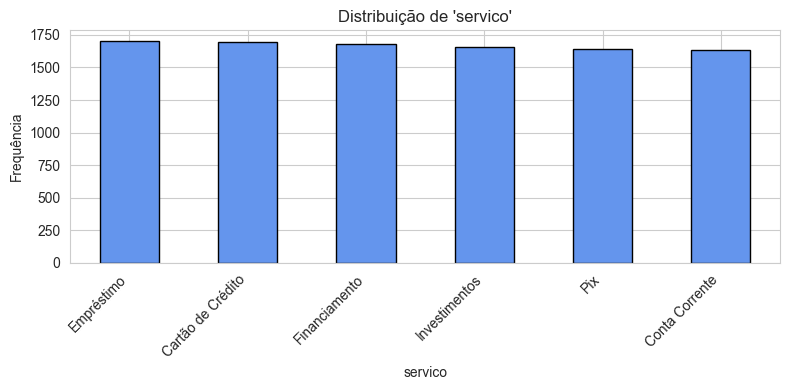

assunto: 22 valores únicos


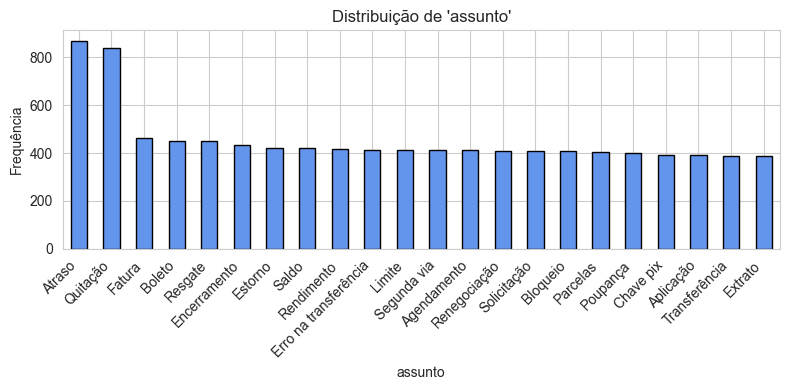

motivo: 8 valores únicos


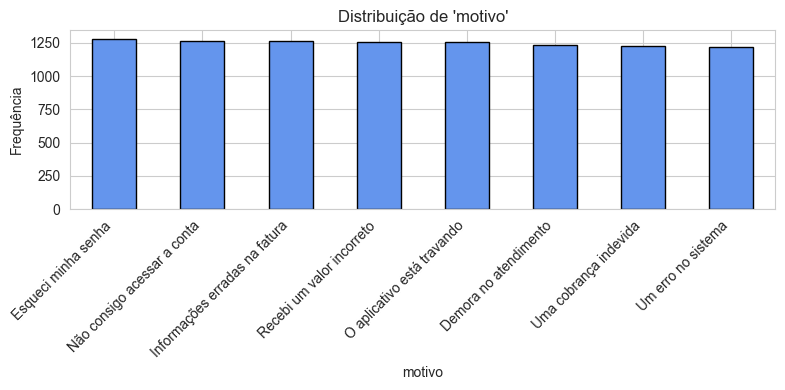

resolvido: 2 valores únicos


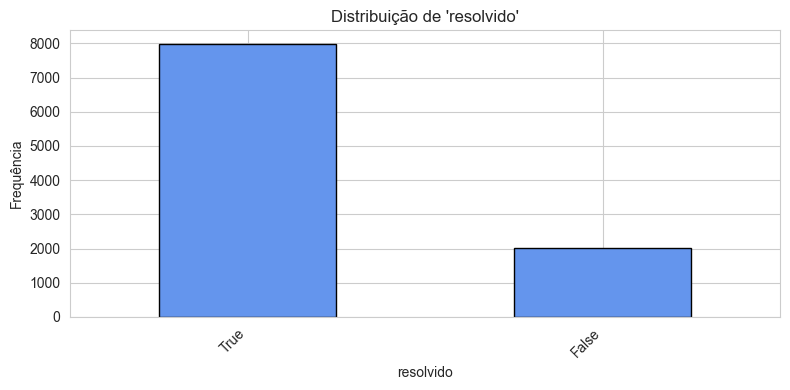

In [71]:
analise_exploratoria(df)

In [72]:
# Coluna transcrição (Tem duplicidades?)

df['transcricao'].duplicated().value_counts()

transcricao
False    9995
True        5
Name: count, dtype: int64

Parecer da análise exploratória

- A coluna de transcrição possui 179 valores duplicados | Ação: Remover as linhas
- As colunas serviços e Motivo estão balanceadas | Ação: Nenhuma
- A coluna Assunto possui duas classes majoritárias | Ação: Verificar se teremos impacto no modelo por conta do desbalanceamento da classe
- Trata-se de um Problema multiclasse
    

In [25]:
df.head()

,transcricao,servico,assunto,motivo
0,"Cliente: Boa tarde\nAtendente: Olá, em que pos...",Conta Corrente,Transferência,O aplicativo está travando
1,"Cliente: Oi, tudo bem?\nAtendente: Olá, em que...",Empréstimo,Solicitação,O aplicativo está travando
2,"Cliente: Boa tarde\nAtendente: Olá, em que pos...",Empréstimo,Atraso,Uma cobrança indevida
3,"Cliente: Bom dia\nAtendente: Olá, em que posso...",Financiamento,Boleto,O aplicativo está travando
4,"Cliente: Oi com quem eu falo\nAtendente: Olá, ...",Conta Corrente,Saldo,Um erro no sistema


In [73]:
# Remnovendo as linhas duplicadas
df.drop_duplicates(subset='transcricao',inplace=True)

In [74]:
# Verificando se deu certo
df.transcricao.duplicated().value_counts()

transcricao
False    9995
Name: count, dtype: int64

In [75]:
df.shape

(9995, 5)

# Preparação

In [76]:
# Vetorização e Treino
clf = SpacyTextClassifier(task_type="auto", base_model='logistic')  # binary ou  multiclass
X,y = clf.prepare_data(df.transcricao, df.servico)
X_train, X_test ,y_train,y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=42)

Carregando modelo spaCy: pt_core_news_md
Limpando e vetorizando os textos...


100%|██████████████████████████████████████████████████████████████████████████████| 9995/9995 [02:36<00:00, 63.83it/s]


# Treino e Teste

In [53]:
y.shape

(9821,)

🔄 Treinando modelo base...
✅ Modelo treinado com sucesso!
A Avaliação por threshold é recomendada apenas para classificação binária.

📊 Classification Report
                   precision    recall  f1-score   support

Cartão de Crédito       0.98      0.98      0.98       509
   Conta Corrente       0.94      0.89      0.92       489
       Empréstimo       0.93      0.92      0.92       509
    Financiamento       0.95      0.97      0.96       503
    Investimentos       0.91      0.94      0.93       497
              Pix       0.97      0.98      0.97       492

         accuracy                           0.95      2999
        macro avg       0.95      0.95      0.95      2999
     weighted avg       0.95      0.95      0.95      2999


📊 Matriz de Confusão


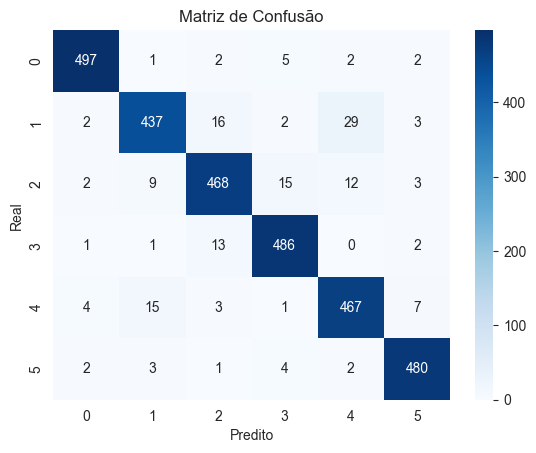

Acurácia: 0.9453 | Precisão: 0.9454 | Recall: 0.9453 | F1-Score: 0.9452

 🔄 Validação cruzada estratificada (10-fold)...
Accuracy: Média = 0.9464, Desvio Padrão = 0.0060
Precision: Média = 0.9465, Desvio Padrão = 0.0059
Recall: Média = 0.9464, Desvio Padrão = 0.0060
F1: Média = 0.9463, Desvio Padrão = 0.0059


In [77]:
clf.train(X_train,y_train)
clf.evaluate_threshold_cv(X,y)
clf.evaluate(X_test,y_test,use_best_threshold =True)
clf.cross_validate(X,y,use_best_threshold =True)

# Assunto

In [78]:
y = np.array(df.assunto)

In [79]:
X_train, X_test ,y_train,y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=42)

🔄 Treinando modelo base...
✅ Modelo treinado com sucesso!
A Avaliação por threshold é recomendada apenas para classificação binária.

📊 Classification Report
                       precision    recall  f1-score   support

          Agendamento       0.86      0.91      0.89       123
            Aplicação       0.95      0.90      0.93       117
               Atraso       0.94      0.98      0.96       261
             Bloqueio       0.90      0.93      0.92       123
               Boleto       0.89      0.94      0.91       135
            Chave pix       0.99      1.00      1.00       118
         Encerramento       0.91      0.90      0.90       131
Erro na transferência       0.98      0.97      0.98       124
              Estorno       0.93      0.87      0.90       127
              Extrato       0.91      0.88      0.89       116
               Fatura       1.00      0.98      0.99       138
               Limite       0.93      0.95      0.94       124
             Parcelas 

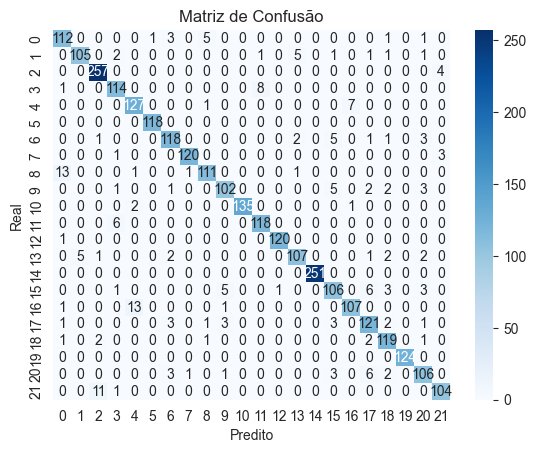

Acurácia: 0.9343 | Precisão: 0.9348 | Recall: 0.9343 | F1-Score: 0.9342

 🔄 Validação cruzada estratificada (10-fold)...
Accuracy: Média = 0.9327, Desvio Padrão = 0.0047
Precision: Média = 0.9340, Desvio Padrão = 0.0048
Recall: Média = 0.9327, Desvio Padrão = 0.0047
F1: Média = 0.9325, Desvio Padrão = 0.0047


In [80]:
clf.train(X_train,y_train)
clf.evaluate_threshold_cv(X,y)
clf.evaluate(X_test,y_test,use_best_threshold =True)
clf.cross_validate(X,y,use_best_threshold =True)

# Motivo

In [81]:
# Motivo
y = np.array(df.motivo)

In [82]:
X_train, X_test ,y_train,y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=42)

🔄 Treinando modelo base...
✅ Modelo treinado com sucesso!
A Avaliação por threshold é recomendada apenas para classificação binária.

📊 Classification Report
                               precision    recall  f1-score   support

        Demora no atendimento       0.83      0.81      0.82       371
          Esqueci minha senha       0.93      0.87      0.90       384
Informações erradas na fatura       0.90      0.85      0.87       379
  Não consigo acessar a conta       0.87      0.86      0.87       379
   O aplicativo está travando       0.86      0.89      0.88       376
    Recebi um valor incorreto       0.96      0.88      0.92       378
           Um erro no sistema       0.68      0.82      0.74       365
        Uma cobrança indevida       0.89      0.87      0.88       367

                     accuracy                           0.86      2999
                    macro avg       0.86      0.86      0.86      2999
                 weighted avg       0.87      0.86      0.8

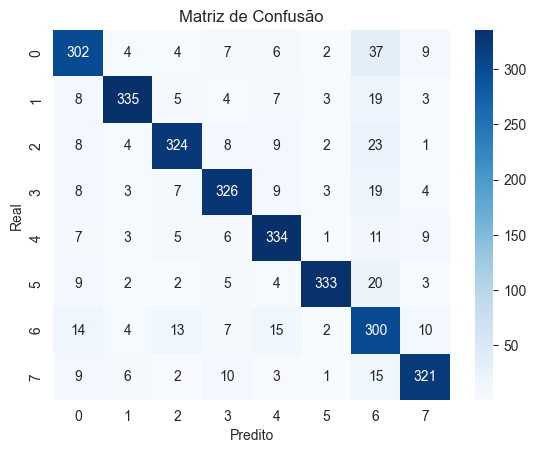

Acurácia: 0.8586 | Precisão: 0.8653 | Recall: 0.8586 | F1-Score: 0.8606

 🔄 Validação cruzada estratificada (10-fold)...
Accuracy: Média = 0.8581, Desvio Padrão = 0.0062
Precision: Média = 0.8712, Desvio Padrão = 0.0057
Recall: Média = 0.8581, Desvio Padrão = 0.0062
F1: Média = 0.8617, Desvio Padrão = 0.0061


In [83]:
clf.train(X_train,y_train)
clf.evaluate_threshold_cv(X,y)
clf.evaluate(X_test,y_test,use_best_threshold =True)
clf.cross_validate(X,y,use_best_threshold =True)

# Resolução

In [86]:
y = np.array(df.resolvido)


In [87]:
X_train, X_test ,y_train,y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=42)

🔄 Treinando modelo base...
✅ Modelo treinado com sucesso!


 Avaliando thresholds com cross-validation (10-fold)...


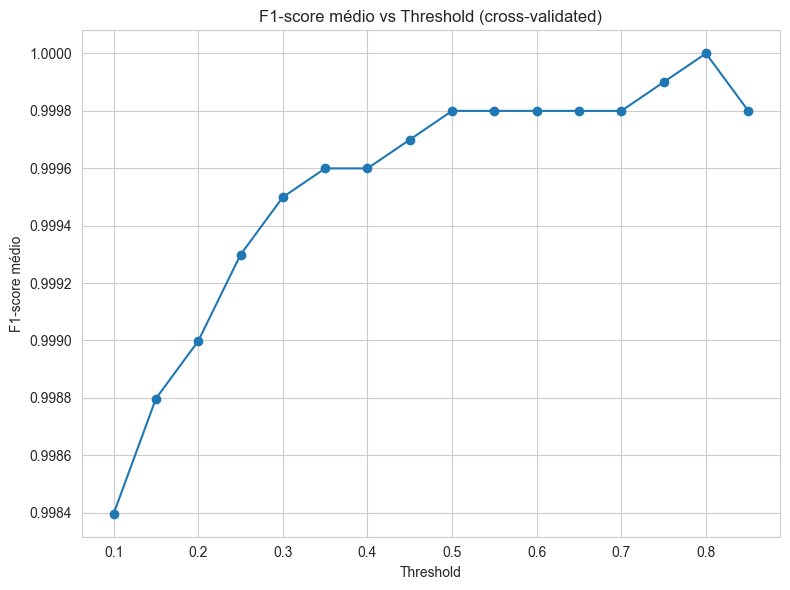

🔥 Melhor threshold médio: 0.80 com F1-score: 1.0000

🔍 Usando threshold global armazenado: 0.80

📊 Classification Report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       606
        True       1.00      1.00      1.00      2393

    accuracy                           1.00      2999
   macro avg       1.00      1.00      1.00      2999
weighted avg       1.00      1.00      1.00      2999


📊 Matriz de Confusão


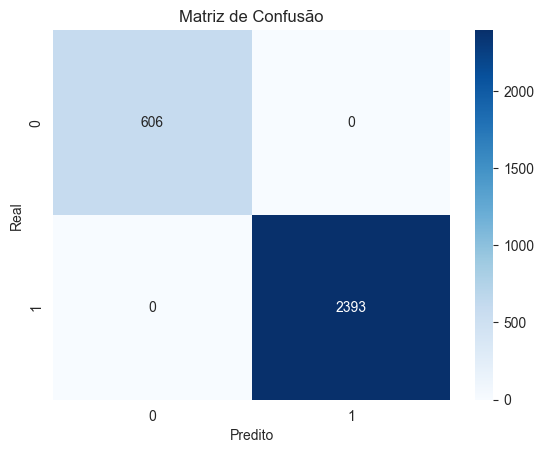

Acurácia: 1.0000 | Precisão: 1.0000 | Recall: 1.0000 | F1-Score: 1.0000

 🔄 Validação cruzada estratificada (10-fold)...
Accuracy: Média = 1.0000, Desvio Padrão = 0.0000
Precision: Média = 1.0000, Desvio Padrão = 0.0000
Recall: Média = 1.0000, Desvio Padrão = 0.0000
F1: Média = 1.0000, Desvio Padrão = 0.0000


In [88]:
clf.train(X_train,y_train)
clf.evaluate_threshold_cv(X,y)
clf.evaluate(X_test,y_test,use_best_threshold =True)
clf.cross_validate(X,y,use_best_threshold =True)